# Calibration of Local Stochastic Volatility Models to Market Smiles 

## Exercise: Black-Scholes Robustness Formula
** (Assigment is due on April 3rd, 11:55pm) **

Let $S$ be the price of a risky asset (say a stock) which pays no dividend or repo. For the sake of simplicity, we assume zero interest rates. We assume that, under a risk-neutral probability $\mathbb{Q}$, its dynamics is

$$
d S_t = \sigma_t S_t dW_t \qquad (1)
$$

for some stochastic process $\sigma_t$ (stochastic volatility or stochastic local volatility for instance). Let us consider the case of an agent who is (wrongfully) assuming that the stock follows a Black-Scholes dynamics

$$
d S^{\textrm{BS}}_t = \sigma_{\textrm{BS}} S^{\textrm{BS}}_t d W_t,
$$

for some constant value of the volatility $\sigma_{\textrm{BS}}$. In this model, the Call option price of maturity $T$ and strike $K$ has a closed-form expression $C_{\textrm{BS}} \left(t, S_t; \sigma_{\textrm{BS}}, K, T \right)$.

**Question 1:** Recall the PDE satisfied by $C_{\textrm{BS}}(t,x)$.

**Question 2:** Applying Itô's formula, compute the differential $d C_{\textrm{BS}}(t, S_t; \sigma_{\textrm{BS}}, K, T)$.

**Question 3:** Using Question 1, prove that (omitting the arguments in $\partial_{x}^2 C_{\textrm{BS}}$ and $\partial_{xx}^2 C_{\textrm{BS}}$)

$$
d C_{\textrm{BS}}(t, S_t; \sigma_{\textrm{BS}}, K, T) =  \frac{1}{2} \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} dt + \partial_x C_{\textrm{BS}} dS_t.
$$

**Question 4:** Integrating between $0$ and $T$, prove that

$$
(S_T - K)_+ - C_{\textrm{BS}}(0, S_0, K, \sigma_{\textrm{BS}}, T) = \frac{1}{2} \int_0^T \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} dt + \int_0^T \partial_x C_{\textrm{BS}} dS_t.
$$


**Question 5:** Interpret the above formula in terms of the (Gamma-Theta) P&L of a delta-hedged Call option in Model (1), when using Black-Scholes formula to compute the Delta.
    
**Question 6:** Robustness of the Black Scholes formula: Denoting $C(K,T)=\mathbb{E}[(S_T - K)_+]$, prove that

$$
C(K, T) = C_{\textrm{BS}}(0, S_0, K, \sigma_{\textrm{BS}}, T) + \frac{1}{2} \mathbb{E} \left[ \int_0^T \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} (t, S_t; \sigma_{\textrm{BS}}, K, T )dt \right]. \qquad (2)
$$

This provides a corrective term to the Black-Scholes formula to price a Call option in Model (1), corresponding to an expectation of the integral of the difference between the square instantaneous volatility and the square Black-Scholes volatility, weighted by the Black-Scholes Gamma at $(t, S_t)$.

## Computing Assignment IV
** (Due date: Thursday, April 3rd, 11:55pm) **

** Part I: Implementing the Black-Scholes Robustness Formula **

- Describe and implement a Monte Carlo procedure exploiting Formula (2) to compute the implied volatility of vanilla options in the following model (stochastic lognormal volatility):

$$
\begin{array}{l}
dS_t = a_t S_t dW^{(1)}_t,\\
d a_t = a_t \gamma dW^{(2)}_t,\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

For convenience, we provide an implementation of the closed-form expressions for the Vanilla option price $C_{\textrm{BS}}$ and the Gamma $\partial_{xx} C_{\textrm{BS}}$ in the Black Scholes model. We also provide a naive volatility inversion routine to compute the Black Scholes implied volatility from an option price.

- Compare and validate your result with the one of a naive Monte Carlo procedure. Compare the variance of the two estimators of implied volatilities.

The numerical values for the model parameters are
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

In [10]:
# Utility functions for lognormal distributions and Black Scholes model

%matplotlib inline
import numpy as np
from scipy.stats import norm

def lognormal_price(stdev, fwd, strike, IsCall):
    """Lognormal price.

    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)
    
    returns        E[(L - K)_+]    if        IsCall == true
    returns        E[(K - L)_+]    if        IsCall == false
    
    - fwd and stdev must be non-negative
    - the  returned value is non-negative
    """
    intrinsic_value = max(fwd - strike, 0.0) if IsCall else max(strike - fwd, 0.0)
    time_value = lognormal_time_value(stdev, fwd, strike)
    return intrinsic_value + time_value

lognormal_price = np.vectorize(lognormal_price)

def lognormal_time_value(stdev, fwd, strike):
    """Lognormal time value.

    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)
    
    returns                       E[(L - K)_+] - (E[L] - K)_+
    which is also equal to        E[(K - L)_+] - (K - E[L])_+

    - fwd and stdev must be non-negative
    - returned value is non-negative
    """
    if strike <= 0.0 or stdev <= 0.0:
        return 0.0
    else:
        d2 = -np.log(strike / fwd) / stdev - 0.5 * stdev
        d1 = d2 + stdev
        if strike >= fwd:
            return fwd * norm.cdf(d1) - strike * norm.cdf(d2)
        else:
            return strike * norm.cdf(-d2) - fwd * norm.cdf(-d1)

lognormal_time_value = np.vectorize(lognormal_time_value)

def lognormal_gamma(stdev, fwd, strike):                        
    """Lognormal Gamma.
    
    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)

    returns        d2 Call / d fwd2   if        IsCall == True
    returns        d2 Put / d fwd2    if        IsCall == False
    
    - fwd and stdev must be non-negative
    """
    if strike <= 0.0 or stdev <= 0.0:
        return 0.0
    else:
        d1 = -np.log(strike / fwd) / stdev + 0.5 * stdev
        return norm.pdf(d1) / (stdev * fwd)

lognormal_gamma = np.vectorize(lognormal_gamma)

def black_scholes_time_value(volatility, fwd, maturity, strike):
    """Time-value of a Call or Put option in the Black-Scholes model.
    
    dS_t = S_t volatility dW_t
    S_0 = fwd
       
    time_value = E[(S_T - strike)+] - (E[S_T] - strike)_+

    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity has to be non-negative')
    return lognormal_time_value(volatility * np.sqrt(maturity), fwd, strike)

def black_scholes_price(volatility, fwd, maturity, strike, IsCall):
    """Price of a Call or Put option in the Black-Scholes model.

    dS_t = S_t volatility dW_t
    S_0 = fwd

    returns        E[(S_T - strike)_+]    if   IsCall == true
`   returns        E[(strike - S_T)_+]    if   IsCall == false
   
    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity must be non-negative')
    return lognormal_price(volatility * np.sqrt(maturity), fwd, strike, IsCall)

def black_scholes_gamma(volatility, fwd, maturity, strike):
    """Gamma of a Call or Put option in the Black-Scholes model.

       dS_t = S_t volatility dW_t
       S_0 = fwd

    returns        d2 E[(S_T - strike)_+] / dfwd2   if   IsCall == true
    returns        d2 E[(strike - S_T)_+] / dfwd2   if   IsCall == false
   
    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity has to be non-negative')
    return lognormal_gamma(volatility * np.sqrt(maturity), fwd, strike)

In [11]:
import matplotlib.pyplot as plt

In [12]:
# Simple plot of the Black Scholes Gamma

strikes = np.linspace(50, 200, 100)
plt.plot(strikes, black_scholes_gamma(0.2, 100.0, 1.0, strikes))
plt.title('Black Scholes Gamma as a function of strike')
plt.show()

In [13]:
# Simple plot of the Black Scholes price

strikes = np.linspace(50, 200, 100)
plt.plot(strikes, black_scholes_price(0.2, 100.0, 1.0, strikes, True))
plt.title('Black Sholes price as a function of strike')
plt.show()

In [14]:
# Naive implementation of volatility inversion.

from scipy.optimize import brentq

def time_value_vol_inversion(strike, maturity, fwd, time_value):
    """Implied volatility computation for a given time value.
    
    Value of volatility such that:
    
    ``black_scholes_time_value(volatility, maturity, fwd, strike) == time_value``.
    
    - maturity and time_value must be non-negative
    - the returned value is non-negative
    """ 
    if time_value == 0.0:
        return 0.0
    def func(volat):
        return black_scholes_time_value(volat, fwd, maturity, strike) - time_value
    return brentq(func, 0.01, 3.00)

def vol_inversion(strike, maturity, fwd, option_price, IsCall):
    """Implied volatility computation for a given option price.
    
    Value of volatility such that:
    
    ``black_scholes_price(volatility, maturity, fwd, strike, IsCall) == option_price``.
    
    - maturity must be non-negative
    - time value must be non-negative
    - the returned value is non-negative
    """
    if IsCall:
        time_value = option_price - max(fwd - strike, 0.0)
    else:
        time_value = option_price - max(strike - fwd, 0.0)
    return time_value_vol_inversion(strike, maturity, fwd, time_value)

In [15]:
# Simple volatility inversion test.
maturity = 1.0
strike = 100.0
fwd = 100.0
option_price = black_scholes_price(0.3, fwd, maturity, strike, True)
vol_inversion(strike, maturity, fwd, option_price, True)

0.3

In [16]:
#create a function that simulates the path of the underlying using the stochastic lognormal volatility process
def lognormal_path(a0,S0,T,gamma,rho,nb_steps,nb_sim):
    a = np.zeros((nb_steps+1,nb_sim))
    S = np.zeros_like(a)
    W1 = np.zeros_like(a)
    W2 = np.zeros_like(a)
    Z = np.zeros_like(a)
    dt = T/nb_steps
    #first generate independant random normal variables
    W1 = np.random.randn(nb_steps+1, nb_sim)
    Z = np.random.randn(nb_steps+1, nb_sim)
    W2 = rho*W1 + np.sqrt(1-rho**2)*Z
    #set the starting values
    a[0] = a0
    S[0] = S0
    for i in range(0,nb_steps):
        #compute the new volatility
        a[i+1,:] = np.maximum(a[i,:],0) + gamma*np.maximum(a[i,:],0)*np.sqrt(dt)*W2[i+1,:]
        S[i+1,:] = S[i,:]*np.exp(-0.5*a[i,:]**2*dt+a[i,:]*np.sqrt(dt)*W1[i,:])
    return(S,a)

In [46]:
path, vol = lognormal_path(0.3,100,1,0.5,-0.5,100,1000)

In [47]:
plt.plot(path[:,:3])
plt.show()

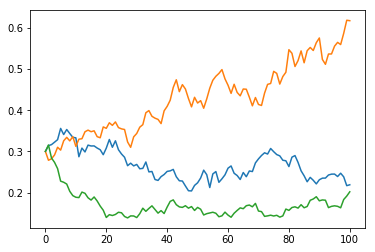

In [48]:
plt.plot(vol[:,:3])
plt.show()

In [103]:
#we write a function that computes the price of a call using the black-scholes robustness formula
#this function doesn't work since the black_scholes gamma function doesn't accept multiple maturities
def robust_price(at,St,K,T, vol_BS):
    S0 = St[0,0]
    dt = T/(len(at)-1)
    nb_sim = St.shape[1]
    C_BS = black_scholes_price(vol_BS, S0, T, K, True)
    maturity = np.tile(np.linspace(1,0,len(at)),(nb_sim,1)).T
    gamma_BS = black_scholes_gamma(vol_BS, St, maturity, strike)
    adj = (1/(len(at)-1))*np.sum(np.sum((at - vol_BS)*gamma_BS*(St**2)*dt,axis = 0))
    return(C_BS + adj)



In [162]:
price = robust_price(vol, path, 100, 1, 0.3)
print(price)


KeyboardInterrupt: 

In [20]:
def robust_price2(at,St,K,T, vol_BS):
    S0 = St[0,0]
    dt = T/(len(at)-1)
    nb_sim = St.shape[1]
    nb_steps = St.shape[0]-1
    C_BS = black_scholes_price(vol_BS, S0, T, K, True)
    #maturity = np.tile(np.linspace(1,0,len(at)),(nb_sim,1)).T
    #gamma_BS = black_scholes_gamma(vol_BS, St, maturity, strike)
    #adj = (1/(len(at)-1))*np.sum(np.sum((at - vol_BS)*gamma_BS*(St**2)*dt,axis = 0))
    adj = 0
    for i in range(0,nb_sim):
        for t in range(0,nb_steps+1):
            adj += (at[t,i]**2-vol_BS**2)*black_scholes_gamma(vol_BS,St[t,i],T-t*dt,K)*St[t,i]**2*dt
    adj = adj/nb_sim
    return(C_BS + adj)

In [21]:
robust_price2(vol[:,:100],path[:,:100],100,1,0.3)

11.761707320682108

In [49]:
Ks = np.linspace(50,200,10)
price = []
for k in Ks:
    price.append(robust_price2(vol,path,k,1,0.3))
    #print(price)
print(price)
#using 100000 simulations we find the following prices:
#price = [50.94186958870614, 35.89031183541011, 22.131228993446772, 11.328043871462242, 4.771615772628614, 1.7434468883058007, 0.6015142788260645, 0.20950324308797075, 0.07911269167583126, 0.03483329216696317]

[50.92589352062167]
[50.92589352062167, 35.99888035648666]
[50.92589352062167, 35.99888035648666, 22.395763673044794]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925, 1.8405306892863675]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925, 1.8405306892863675, 0.5893999362269307]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925, 1.8405306892863675, 0.5893999362269307, 0.24130824726249256]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925, 1.8405306892863675, 0.5893999362269307, 0.24130824726249256, 0.11557775716781593]
[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925, 1.8405306892

In [64]:
#price = [50.94186958870614, 35.89031183541011, 22.131228993446772, 11.328043871462242, 4.771615772628614, 1.7434468883058007, 0.6015142788260645, 0.20950324308797075, 0.07911269167583126, 0.03483329216696317]
print(price)

[50.92589352062167, 35.99888035648666, 22.395763673044794, 11.731447067607299, 4.975925253374925, 1.8405306892863675, 0.5893999362269307, 0.24130824726249256, 0.11557775716781593, 0.05840778159011911]


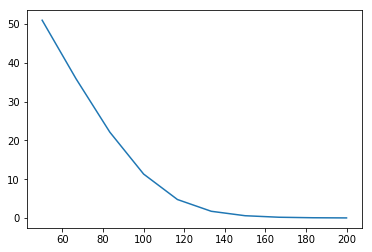

In [25]:
plt.plot(Ks,price)
plt.show()

In [65]:
imp_vol = []
for i in range(0,len(Ks)):
    imp_vol.append(vol_inversion(Ks[i], 1, 100, price[i], True))
print(imp_vol)

[0.4605877341192272, 0.40251049984472076, 0.3391406309174602, 0.2951313918737795, 0.26571859095252764, 0.25251392359836816, 0.2434369774908335, 0.24983904243128335, 0.25966569528101313, 0.26845556908898893]


In [37]:
#naive inversion method
#we price the option using the monte carlo simulation of the process
def MC_price(St,K, IsCall):
    #since there is no interest rate the price is simply the average of the payoff
    if IsCall:
        payoff = np.maximum(St[len(St)-1]-K,0)
    else:
        payoff = np.maximum(K-St[len(St)-1],0)
    price = np.average(payoff)
    return(price)


In [38]:
#this naive inversion method uses put prices for strikes below 100 to ensure convergence of the root finding method
mc_p = []
for k in Ks:
    if k < 100:
        mc_p.append(MC_price(path,k,False))
    else:
        mc_p.append(MC_price(path,k,True))
print(mc_p)

[0.8530009735938634, 2.6430694553252234, 6.828165512709754, 8.332840159583858, 3.5985410630028167, 1.263720004101019, 0.4245992756463146, 0.16828483377583678, 0.06865329764152096, 0.023016240625158873]


In [66]:
plt.plot(Ks,mc_p)
plt.show

<function matplotlib.pyplot.show>

In [40]:

imp_vol_naive = []
for i in range(0,len(Ks)):
    if Ks[i] < 100:
        imp_vol_naive.append(vol_inversion(Ks[i],1,100,mc_p[i],False))
    else:
        imp_vol_naive.append(vol_inversion(Ks[i],1,100,mc_p[i],True))
print(imp_vol_naive)

[0.4521835472790396, 0.4013392640732976, 0.37409487395946023, 0.20925448134323305, 0.22648669496261845, 0.2265428580241269, 0.2285786184835329, 0.23692311003408034, 0.24381474490425006, 0.24427615623574203]
[ 50.          66.66666667  83.33333333 100.         116.66666667
 133.33333333 150.         166.66666667 183.33333333 200.        ]


In [91]:
plt.plot(Ks,imp_vol_naive, c = "b")
plt.plot(Ks,imp_vol, c = "r")
plt.show()
#we can see that the robustness method yields a smoother smile than the monte carlo method
#the results could be improved using more simulations, however due to time constraints we cannot use too many simulations to invert
#the prices

In [72]:
#method 2
#inversion of vol_BS in the robustness formula by equating it to the MC_price (expected payoff)
def inversion2(at,St,strike,T, MC_price, v_BS):
    S0 = St[0,0]
    dt = T/(len(at)-1)
    nb_sim = St.shape[1]
    nb_steps = St.shape[0]-1
    #we use puts to compute the prices on lower strikes in order to invert the volatility
    call = True
    if strike < 100: call = False
    C_BS = black_scholes_price(v_BS, S0, T, strike, call)
    tmp =  C_BS - MC_price
    adj = 0
    for i in range(0,nb_sim):
        for t in range(0,nb_steps+1):
            adj += (at[t,i]**2-v_BS**2)*black_scholes_gamma(v_BS,St[t,i],T-t*dt,strike)*St[t,i]**2*dt
    adj = adj/nb_sim
    return(tmp + adj)

In [86]:
#testing the method
i = 5
brentq(lambda v: inversion2(vol[:,:100],path[:,:100],Ks[i],1,mc_p[i],v),0.001,2)

0.323506989951615

In [87]:
i = 0
res =[]
for k in Ks:
    print(k)
    tmp = brentq(lambda v: inversion2(vol[:,:100],path[:,:100],k,1,mc_p[i],v),0.001,2)
    res.append(tmp)
    i+=1

50.0
66.66666666666667
83.33333333333334
100.0
116.66666666666667
133.33333333333334
150.0
166.66666666666669


ValueError: f(a) and f(b) must have different signs

In [88]:
res
#results obtained from the vol inversion:
#[0.3782204246884494,0.3156705595978106,0.24251097123289742,0.3676826344381394,0.3263437741023298,0.323506989951615,0.3140298471242324]
#using only 100 simulations doesn't allow to find a root at the higher strikes
#however due to time constraints running the full simulations would take hours


[0.3782204246884494,
 0.3156705595978106,
 0.24251097123289742,
 0.3676826344381394,
 0.3263437741023298,
 0.323506989951615,
 0.3140298471242324]

In [90]:
plt.plot(Ks[:len(res)],res)
plt.show()

** Part II: The particle method and the smile calibration problem **

Let us consider a modified version of the previous model, where we add local volatility term (or leverage function) $l$ in the stock dynamics:

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
d a_t = a_t \gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

The goal is to find a leverage function $l(t, x)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that all the vanilla option prices in the market are such that they match those of a Black-Scholes model, ie. the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 30\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,x) \equiv 30\%$.

** Implementation **
- Implement the particle method studied in class to set the leverage function $l$. For this purpose, you may use the non-parametric regression routines provided in the previous assignments.
- Using the Monte Carlo method devised in the previous section, check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 30\%$.

** Interpretation **
- While setting $\rho = 0\%$, plot the calibrated leverage function $l(t, S)$ as a function of the spot value for a fixed maturity e.g. $t = T$. Plot the corresponding smile for the pure stochastic volatility model ($l \equiv 1$). By changing the value of the volatility of volatility, comment on the dependence of the shape of the leverage function on the volatility of volatility $\gamma$. Suggested values for $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- For $\gamma = 50\%$, study the joint dependence of the slope of the leverage function and of the smile of the pure stochastic volatility model on the correlation parameter $\rho$.

In [92]:
#non parametric regression function from the previous assignment
def reg_non_param(x, bdwidth, x_sample, y_sample, k_type):
    """Values of the non-parametric regression of Y wrt X using a Gaussian kernel.

    Parameters
    ----------
    x: numpy array, one dimensional
        Values at which the regression is evaluated
    bdwidth: positive float, value of the bandwidth parameter
    x_sample: numpy array, one dimensional, non-empty
        x values of the sample
    y_sample: numpy array, one dimensional
        y values of the sample, must have the same length as x_sample.    
    """
    #The parameter kern_type is added in order to choose which kernel to use for the regression
    def kern(u, x, kern_type):
        if kern_type == "Gaussian":
            """Gaussian kernel function"""
            return np.exp(-(u[:, np.newaxis] - x) ** 2 / (2 * bdwidth ** 2))
        elif kern_type == "Epa":
            #epanechnikov kernel
            return 0.75*(1-((u[:, np.newaxis] - x)/bdwidth)**2)*(np.abs((u[:, np.newaxis] - x)/bdwidth)<=1)
        elif kern_type == "uniform":
            return 0.5*(np.abs((u[:, np.newaxis] - x)/bdwidth)<=1)
        elif kern_type == "tri-cube":
            return (1-(np.abs((u[:, np.newaxis] - x)/bdwidth))**3)**3*(np.abs((u[:, np.newaxis] - x)/bdwidth)<=1)
        
    return np.sum(kern(x_sample, x, k_type) * y_sample[:, np.newaxis], axis=0) \
        / np.sum(kern(x_sample, x, k_type), axis=0)

In [93]:
def particle_method(S0,a0,T,gamma,rho,vol_dup,nb_steps,nb_sim):
    a = np.zeros((nb_steps+1,nb_sim))
    S = np.zeros_like(a)
    W1 = np.zeros_like(a)
    W2 = np.zeros_like(a)
    Z = np.zeros_like(a)
    l = np.zeros_like(a)
    dt = T/nb_steps
    #first generate independant random normal variables
    W1 = np.random.randn(nb_steps+1, nb_sim)
    Z = np.random.randn(nb_steps+1, nb_sim)
    W2 = rho*W1 + np.sqrt(1-rho**2)*Z
    #initial values
    a[0,:] = a0
    S[0,:] = S0
    l[0,:] = 1
    for t in range(0,nb_steps):
        #compute the next step vol
        a[t+1,:] = np.maximum(a[t,:],0) + gamma*np.maximum(a[t,:],0)*np.sqrt(dt)*W2[t,:]
        #compute the next step price using the previous step leverage function
        S[t+1,:] = S[t,:]*np.exp(-0.5*(l[t,:]*a[t,:])**2*dt+a[t,:]*l[t,:]*np.sqrt(dt)*W1[t,:])
        #compute the leverage function to be used in the next step
        l[t+1,:] = vol_dup/np.sqrt(reg_non_param(S[t,:],0.7,S[t,:],a[t,:]**2,"Gaussian"))
    return(a,S,l)
            

In [99]:
vol_particle, path_particle, leverage = particle_method(100,0.3,1,0.5,-0.5,0.3,100,1000)

In [100]:
plt.plot(path_particle[:,:3])
plt.show

<function matplotlib.pyplot.show>

In [101]:
plt.plot(vol_particle[:,:3])
plt.show

<function matplotlib.pyplot.show>

<function matplotlib.pyplot.show>

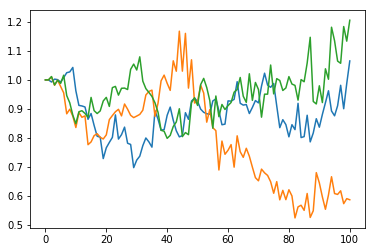

In [102]:
plt.plot(leverage[:,:3])
plt.show

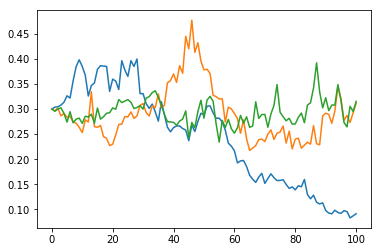

In [103]:
plt.plot(vol_particle[:,:3]*leverage[:,:3])
plt.show()

In [111]:
#use the robustness formula to compute the price and then invert
#vol_inversion(strike, maturity, fwd, option_price, IsCall)
vol_imp_part = []
for k in Ks:
    price_particle = robust_price2(vol_particle[:,:1000]*leverage[:,:1000],path_particle[:,:1000],k,1, 0.3)
    print(price_particle)
    tmp = vol_inversion(k, 1, 100, price_particle, True)
    vol_imp_part.append(tmp)

50.08412675565548
34.35931980518369
21.206867164657183
11.8588833145693
6.109623802186647
2.992631821605621
1.381334950623897
0.610532980079095
0.2621706170262259
0.11525091696780748


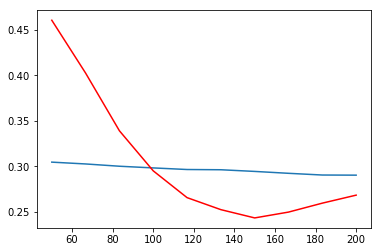

In [112]:
#the graph shows that implied volatility that we get from the calibrated leverage function is much closer to 30%
#than the previous simulations. This would suggest that using the levrage function does allow to calibrate the stochastic volaitlity
#model to reflect observed option prices.
plt.plot(Ks,vol_imp_part)
plt.plot(Ks,imp_vol,c = "r")
plt.show()

In [113]:
#using the second method use the test function and invert
###########
###########
###Need to check this method as it returns an error when inverting... try to rewrite the function properly
###########
###########
mc_p_part = []
for k in Ks:
    if k < 100:
        mc_p_part.append(MC_price(path_particle,k,False))
    else:
        mc_p_part.append(MC_price(path_particle,k,True))
print(mc_p_part)

[0.15184609740134478, 1.1563937507110398, 4.939006372685435, 12.261881199011494, 6.731858294699316, 3.5634842558685675, 1.925980395041813, 1.0718520492106196, 0.6268518490053355, 0.37255139752904254]


In [116]:
#this method doesn't converge at all strikes
#also due to computing time we cannot use all the simulations to invert the price which might be causing the algorithm
#not to converge
i = 1
res_part =[]
for k in Ks[i:]:
    print(k)
    tmp = brentq(lambda v: inversion2(vol_particle[:,:100]*leverage[:,:100],path_particle[:,:100],k,1,mc_p_part[i],v),0.001,2)
    res_part.append(tmp)
    i+=1

66.66666666666667
83.33333333333334
100.0
116.66666666666667
133.33333333333334
150.0


ValueError: f(a) and f(b) must have different signs

In [120]:
plt.plot(Ks[1:6],res_part)
plt.plot(Ks,imp_vol,c = "r")
plt.show()

In [ ]:
#Interpretation

In [121]:
#While setting  ρ=0% , plot the calibrated leverage function  l(t,S) as a function of the spot value for a fixed maturity
#e.g.  t=T . Plot the corresponding smile for the pure stochastic volatility model ( l≡1 ). By changing the value of 
#the volatility of volatility, comment on the dependence of the shape of the leverage function on the volatility of volatility
#γ . Suggested values for  γ: 0%, 25%, 50% , 75%

rho, mat = 0, 1.0
spots = np.linspace(50,150,21)
gammas = [0,0.25,0.5,0.75]

#get the vol, the path and the leverage with rho = 0
vol2_part, path2_part, lev2 = particle_method(100,0.3,mat,0.5,rho,0.3,100,1000)
#get the vol and stock path with the truly stochastic process
path2_sto, vol2_sto = lognormal_path(0.3,100,mat,0.5,rho,100,1000)


In [132]:
t = 99 #the step number to compare
mesh = np.linspace(np.min(path2_part[t,:]), np.max(path2_part[t,:]),100)
res_part = reg_non_param(mesh,5,path2_part[t,:],vol2_part[t,:]*lev2[t,:],"Gaussian")
res_sto = reg_non_param(mesh,5,path2_sto[t,:],vol2_sto[t,:],"Gaussian")

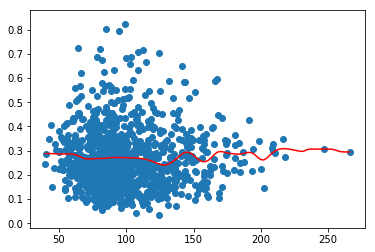

In [133]:
plt.scatter(path2_part[t,:],vol2_part[t,:]*lev2[t,:])
plt.plot(mesh,res_part, c = "r")
plt.show()

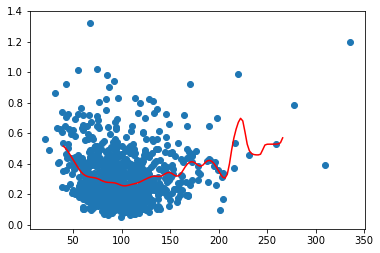

In [134]:
plt.scatter(path2_sto[t,:], vol2_sto[t,:])
plt.plot(mesh,res_sto, c = "r")
plt.show()

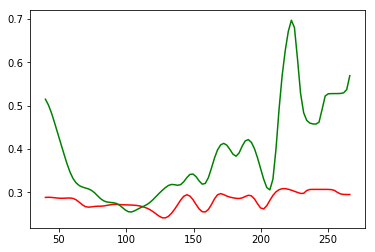

In [135]:
#we observe that with rho = 0 and gamma 0.5 the calibrated leverage function oscillates around 30% while the stochastic 
#volatility has more of a smile shape
plt.plot(mesh,res_part, c = "r")
plt.plot(mesh,res_sto, c = "g")
plt.show()

In [136]:
#testing with different values for gamma
#get the vol, the path and the leverage with rho = 0
gamma = 0
vol2_part_g0, path2_part_g0, lev2_g0 = particle_method(100,0.3,mat,gamma,rho,0.3,100,1000)
#get the vol and stock path with the truly stochastic process
path2_sto_g0, vol2_sto_g0 = lognormal_path(0.3,100,mat,gamma,rho,100,1000)

In [141]:
t = 99 #the step number to compare
mesh = np.linspace(np.min(path2_part_g0[t,:]), np.max(path2_part_g0[t,:]),100)
res_part_g0 = reg_non_param(mesh,0.9,path2_part_g0[t,:],vol2_part_g0[t,:]*lev2_g0[t,:],"Gaussian")
res_sto_g0 = reg_non_param(mesh,0.9,path2_sto_g0[t,:],vol2_sto_g0[t,:],"Gaussian")

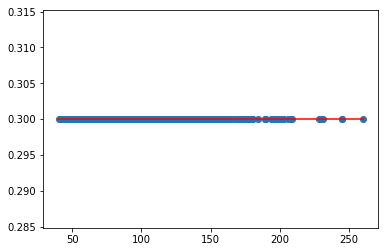

In [142]:
#using gamma = 0 we clearly get a flat "smile" at 30%. This is to be expected as there is no volatility of volatility (gamma = 0)
plt.scatter(path2_part_g0[t,:],vol2_part_g0[t,:]*lev2_g0[t,:])
plt.plot(mesh,res_part_g0, c = "r")
plt.show()

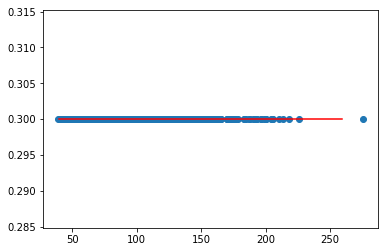

In [143]:
plt.scatter(path2_sto_g0[t,:],vol2_sto_g0[t,:])
plt.plot(mesh,res_sto_g0, c = "r")
plt.show()

In [157]:
t = 99
i = 0
res_part_g = np.zeros((100,len(gammas)))
res_sto_g = np.zeros((100,len(gammas)))
for g in gammas:
    vol2_part_g, path2_part_g, lev2_g = particle_method(100,0.3,mat,g,rho,0.3,100,1000)
    path2_sto_g, vol2_sto_g = lognormal_path(0.3,100,mat,g,rho,100,1000)
    mesh = np.linspace(np.min(path2_part_g[t,:]), np.max(path2_part_g[t,:]),100)
    res_part_g[:,i] = reg_non_param(mesh,5,path2_part_g[t,:],vol2_part_g[t,:]*lev2_g[t,:],"Gaussian")
    res_sto_g[:,i] = reg_non_param(mesh,5,path2_sto_g[t,:],vol2_sto_g[t,:],"Gaussian")
    i+=1

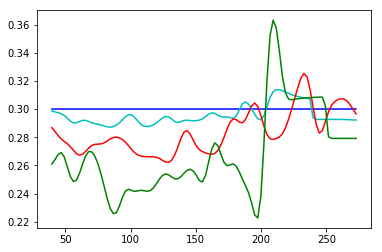

In [161]:
#as expected, the higher the gamma, the more volatile is the curve around 0.3. We notice however that all the curves are below
# 0.3 for lower strikes. Although, the few observations in the high end of the stock prices could account for this difference
plt.plot(mesh,res_part_g[:,0], c = "b")
plt.plot(mesh,res_part_g[:,1], c = "c")
plt.plot(mesh,res_part_g[:,2], c = "r")
plt.plot(mesh,res_part_g[:,3], c = "g")
plt.show()

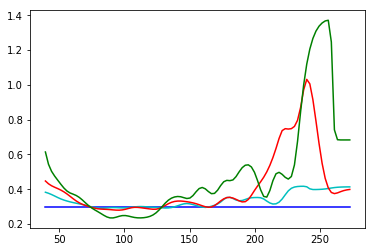

In [162]:
#compared to the previous graph, we can see a "smile" shape in the below curves. Indeed, we notice that the stochastic vol
# model tends to be increase its curvature with gamma, while the calibrated leverage function doesn't change much its curvature
# but it does increase in volatility.
#Also, we notice that almost all the curves are above the 0.3 threshold for the stochastic model, while they are under it for
#the leverage function
plt.plot(mesh,res_sto_g[:,0], c = "b")
plt.plot(mesh,res_sto_g[:,1], c = "c")
plt.plot(mesh,res_sto_g[:,2], c = "r")
plt.plot(mesh,res_sto_g[:,3], c = "g")
plt.show()

In [163]:
#For  γ=50% , study the joint dependence of the slope of the leverage function and of the smile of the pure stochastic volatility
#model on the correlation parameter  ρ.

gamma = 0.5
rhos = [-1,-0.5,0,0.5,1]
t = 99
i = 0
res_part_rho = np.zeros((100,len(rhos)))
res_sto_rho = np.zeros((100,len(rhos)))
for r in rhos:
    vol2_part_rho, path2_part_rho, lev2_rho = particle_method(100,0.3,mat,gamma,r,0.3,100,1000)
    path2_sto_rho, vol2_sto_rho = lognormal_path(0.3,100,mat,gamma,r,100,1000)
    mesh = np.linspace(np.min(path2_part_rho[t,:]), np.max(path2_part_rho[t,:]),100)
    res_part_rho[:,i] = reg_non_param(mesh,5,path2_part_rho[t,:],vol2_part_rho[t,:]*lev2_rho[t,:],"Gaussian")
    res_sto_rho[:,i] = reg_non_param(mesh,5,path2_sto_rho[t,:],vol2_sto_rho[t,:],"Gaussian")
    i+=1

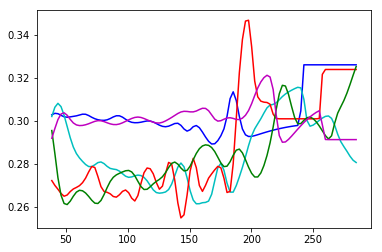

In [166]:
plt.plot(mesh,res_part_rho[:,0], c = "b")
plt.plot(mesh,res_part_rho[:,1], c = "c")
plt.plot(mesh,res_part_rho[:,2], c = "r")
plt.plot(mesh,res_part_rho[:,3], c = "g")
plt.plot(mesh,res_part_rho[:,4], c = "m")
plt.show()

#here we can see that the violet and blue curves have a very similar slope. Those two curves represent the rho = 1 and rho = -1
# respectively. this would suggest that if the processes are perfectly correlated (positively or negatively), the resulting
#calibrated leverage function varies much less around the empirical volatility (0.3) and remains much flatter.


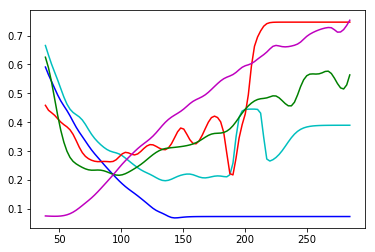

In [168]:
plt.plot(mesh,res_sto_rho[:,0], c = "b")
plt.plot(mesh,res_sto_rho[:,1], c = "c")
plt.plot(mesh,res_sto_rho[:,2], c = "r")
plt.plot(mesh,res_sto_rho[:,3], c = "g")
plt.plot(mesh,res_sto_rho[:,4], c = "m")
plt.show()
#we clearly see a dependence in the smile with rho. Indeed, the negative correlation parameter effect is seen in the blue and cyan
#curves taht decrease with spot price. while the opposite is true for the green and violet curves
#as for the red curve we see no distinguishable pattern, with the exception of the high strikes which could be due to the small
# number of observations in that area.

In [169]:
gamma = 0.5
rhos2 = [-0.5,-0.25,0,0.25,0.5]
t = 99
i = 0
res_part_rho2 = np.zeros((100,len(rhos2)))
#res_sto_rho2 = np.zeros((100,len(rhos2)))
for r in rhos2:
    vol2_part_rho2, path2_part_rho2, lev2_rho2 = particle_method(100,0.3,mat,gamma,r,0.3,100,1000)
    #path2_sto_rho, vol2_sto_rho = lognormal_path(0.3,100,mat,gamma,r,100,1000)
    mesh = np.linspace(np.min(path2_part_rho2[t,:]), np.max(path2_part_rho2[t,:]),100)
    res_part_rho2[:,i] = reg_non_param(mesh,5,path2_part_rho2[t,:],vol2_part_rho2[t,:]*lev2_rho2[t,:],"Gaussian")
    #res_sto_rho[:,i] = reg_non_param(mesh,5,path2_sto_rho[t,:],vol2_sto_rho[t,:],"Gaussian")
    i+=1

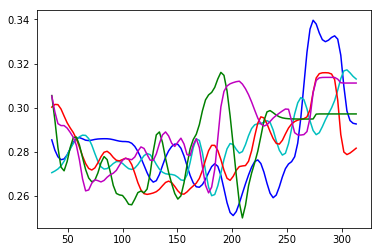

In [170]:
plt.plot(mesh,res_part_rho2[:,0], c = "b")
plt.plot(mesh,res_part_rho2[:,1], c = "c")
plt.plot(mesh,res_part_rho2[:,2], c = "r")
plt.plot(mesh,res_part_rho2[:,3], c = "g")
plt.plot(mesh,res_part_rho2[:,4], c = "m")
plt.show()